In [15]:
import pypulse as pulsar
import matplotlib.pyplot as plt
import numpy as np
import glob
import subprocess
from IPython.display import Image

In [19]:
#-----------------------------------------
# nos quedamos con los .pfds de nbin=1024 y nchan=128
#-----------------------------------------

# creamos una lista con todos los archivos .pfd

timing_folder = './A1/'
psrfits_files = glob.glob(timing_folder+'*pfd')          # lista de archivos .pfd
output = "output.dat"                                    # nombre del archivo de salida del cual vamos leyendo los headers

# para cada archvio .pfd, generamos un archivo con su header y leemos su nbins y su nchan

pfds_1024_128= []
psrfits_files_128= []

for psrfits in psrfits_files:
    
    subprocess.call( "psrstat >" + output + " " + psrfits , shell=True )
    
    n_bins = np.genfromtxt ( output, comments="none", dtype=int, skip_header=1, max_rows=1, usecols=(6) )
    n_chan = np.genfromtxt ( output, comments="none", dtype=int, skip_header=2, max_rows=1, usecols=(5) )
    
    if n_bins==1024:
        if n_chan==128:
            
            temp_pypulse = pulsar.Archive(psrfits)
            pfds_1024_128.append(temp_pypulse)
            psrfits_files_128.append(psrfits)

Loading: ./A1/prepfold_20190608_112623_PSR_0437-4715.pfd
Load time: 1.77 s
Loading: ./A1/prepfold_20190513_132715_PSR_0437-4715.pfd
Load time: 1.61 s
Loading: ./A1/prepfold_20190502_140217_PSR_0437-4715.pfd
Load time: 1.62 s
Loading: ./A1/prepfold_20190503_144606_PSR_0437-4715.pfd
Load time: 1.64 s
Loading: ./A1/prepfold_20190514_122258_PSR_0437-4715.pfd
Load time: 1.66 s
Loading: ./A1/prepfold_20190503_131318_PSR_0437-4715.pfd
Load time: 1.62 s
Loading: ./A1/prepfold_20190512_134505_PSR_0437-4715.pfd
Load time: 1.58 s
Loading: ./A1/prepfold_20190507_163758_PSR_0437-4715.pfd
Load time: 1.66 s
Loading: ./A1/prepfold_20190511_124502_PSR_0437-4715.pfd
Load time: 1.70 s
Loading: ./A1/prepfold_20190510_144844_PSR_0437-4715.pfd
Load time: 1.70 s
Loading: ./A1/prepfold_20190512_122722_PSR_0437-4715.pfd
Load time: 1.62 s
Loading: ./A1/prepfold_20190518_120518_PSR_0437-4715.pfd
Load time: 1.63 s
Loading: ./A1/prepfold_20190520_115652_PSR_0437-4715.pfd
Load time: 1.78 s
Loading: ./A1/prepfold_20

In [20]:
observations = dict(zip(psrfits_files_128, pfds_1024_128))

print(observations)

{'./A1/prepfold_20190608_112623_PSR_0437-4715.pfd': Archive('./A1/prepfold_20190608_112623_PSR_0437-4715.pfd', prepare=True, lowmem=False, verbose=True), './A1/prepfold_20190513_132715_PSR_0437-4715.pfd': Archive('./A1/prepfold_20190513_132715_PSR_0437-4715.pfd', prepare=True, lowmem=False, verbose=True), './A1/prepfold_20190502_140217_PSR_0437-4715.pfd': Archive('./A1/prepfold_20190502_140217_PSR_0437-4715.pfd', prepare=True, lowmem=False, verbose=True), './A1/prepfold_20190503_144606_PSR_0437-4715.pfd': Archive('./A1/prepfold_20190503_144606_PSR_0437-4715.pfd', prepare=True, lowmem=False, verbose=True), './A1/prepfold_20190514_122258_PSR_0437-4715.pfd': Archive('./A1/prepfold_20190514_122258_PSR_0437-4715.pfd', prepare=True, lowmem=False, verbose=True), './A1/prepfold_20190503_131318_PSR_0437-4715.pfd': Archive('./A1/prepfold_20190503_131318_PSR_0437-4715.pfd', prepare=True, lowmem=False, verbose=True), './A1/prepfold_20190512_134505_PSR_0437-4715.pfd': Archive('./A1/prepfold_2019051

In [22]:
# Create single pulse object
# Creat array of best profiles

single_pulses=[]

for observation in pfds_1024_128:
    
    # First crunch in time and frequency
    observation.fscrunch()
    observation.tscrunch()
    
    # Now get array of the best profile
    tmp_singlepulse = observation.getSinglePulses(windowsize=256)
    
    # Align and normalize
    tmp_singlepulse.center_align()
    tmp_singlepulse.normalize()
    
    # Save aligned and normalize in each observation
    single_pulses.append(tmp_singlepulse)
    
# Save single pulse object
sp_observations = dict(zip(psrfits_files_128, single_pulses))

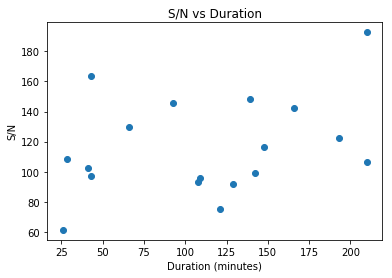

In [23]:
# Plot SN vs duration

duration=[]

allsn = []

for key in observations:
    time = (observations[key].getDuration())/60
    sn = sp_observations[key].getSN()
    bins = observations[key].getNbin()
    duration.append(time)
    allsn.append(sn)
    
plt.close()
plt.scatter(duration, allsn)
plt.title('S/N vs Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('S/N')
plt.show()

In [24]:
# Let us make a template with the best observation

# Take the best SN observation (super inefficient but still fast)

sn_max = np.max(allsn)
for key in observations:
    if sp_observations[key].getSN() == sn_max:
        template_obs = key
        
print(template_obs)
print(sn_max)

./A1/prepfold_20190514_122258_PSR_0437-4715.pfd
192.724324497


/opt/conda/lib/python3.6/site-packages/PyPulse-0.1-py3.6.egg/pypulse/utils.py:549: RuntimeWarning: overflow encountered in exp
  y = np.exp(numer - denom)
/opt/conda/lib/python3.6/site-packages/PyPulse-0.1-py3.6.egg/pypulse/utils.py:552: RuntimeWarning: invalid value encountered in true_divide
  y /= np.max(np.abs(y))


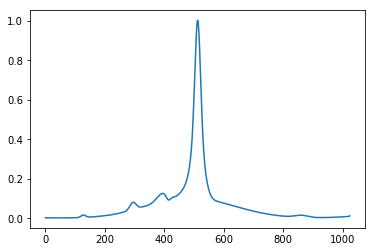

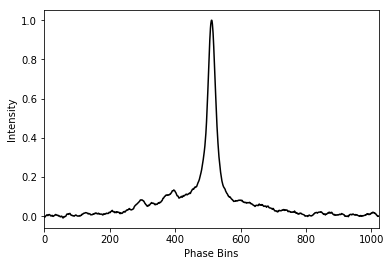

In [25]:
# Make the template
template_sp = observations[template_obs].getSinglePulses(windowsize=32)
template_sp.center_align()
template_sp.normalize()
template = template_sp.vonMises_smoothing(nmax=30)

# Check template
plt.close()
plt.plot(template)
template_sp.plot()
plt.show()